In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# statsmodel 확인
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

2025-01-25 14:29:33.447141: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-25 14:29:34.186431: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv("/home/dlwhdtmd/zongseung/EDA/demand_celcius.csv")

seoul 
chungnam 
gyeongi 
incheon 
chungbuk 
gyongbuk 
gyongnam 
jeonam 
jeonbuk 
other

In [4]:
# 데이테 셋 및 결측치 확인
seoul1 = pd.read_csv("seoul.csv")
chungbuk1 = pd.read_csv("chungbuk.csv")
chungnam1 = pd.read_csv("chungnam.csv")
gyeongi1 = pd.read_csv("gyeongi.csv")
gyongbuk1 = pd.read_csv("gyongbuk.csv")
gyongnam1 = pd.read_csv("gyongnam.csv")
incheon1 = pd.read_csv("incheon.csv")
jeonam1 = pd.read_csv("jeonam.csv")
jeonbuk1 = pd.read_csv("jeonbuk.csv")
other1 = pd.read_csv("other.csv")
jeju1 = pd.read_csv("jeju.csv")

/tmp/ipykernel_2122561/3297737561.py:9: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  jeonam1 = pd.read_csv("jeonam.csv")


In [5]:
jeonbuk1

,Unnamed: 0,tm,rnum,stnId,stnNm,ta,taQcflg,rn,rnQcflg,ws,...,lcsCh,vs,gndSttCd,dmstMtphNo,ts,tsQcflg,m005Te,m01Te,m02Te,m03Te
0,0,2019-01-01 00:00,1,243,부안,-1.7,0.0,NaN,NaN,0.0,...,12.0,1746.0,NaN,NaN,-1.4,0.0,NaN,NaN,NaN,NaN
1,1,2019-01-01 01:00,2,243,부안,-1.8,0.0,NaN,NaN,0.0,...,12.0,1650.0,NaN,NaN,-1.1,0.0,NaN,NaN,NaN,NaN
2,2,2019-01-01 02:00,3,243,부안,-1.6,0.0,NaN,NaN,0.0,...,11.0,1666.0,NaN,NaN,-1.0,0.0,NaN,NaN,NaN,NaN
3,3,2019-01-01 03:00,4,243,부안,-1.6,0.0,NaN,NaN,0.0,...,7.0,1317.0,NaN,NaN,-1.0,0.0,NaN,NaN,NaN,NaN
4,4,2019-01-01 04:00,5,243,부안,-1.8,0.0,NaN,NaN,0.0,...,8.0,1251.0,NaN,NaN,-1.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347321,6691,2024-10-31 19:00,740,254,순창군,14.7,NaN,NaN,NaN,0.8,...,NaN,3071.0,NaN,NaN,18.4,NaN,18.3,17.3,13.3,12.2
347322,6692,2024-10-31 20:00,741,254,순창군,13.7,NaN,NaN,NaN,0.0,...,NaN,2524.0,NaN,NaN,17.6,NaN,17.9,17.0,13.3,12.1
347323,6693,2024-10-31 21:00,742,254,순창군,12.8,NaN,NaN,NaN,0.8,...,NaN,1424.0,NaN,NaN,16.5,NaN,17.5,16.7,13.1,12.0
347324,6694,2024-10-31 22:00,743,254,순창군,12.1,NaN,NaN,NaN,0.2,...,NaN,1388.0,NaN,NaN,15.6,NaN,17.2,16.4,12.9,12.1


In [6]:
# 흑산도 제거
jeonbuk1 = jeonbuk1[jeonbuk1['stnNm'] != '흑산도']

In [7]:
#  결측치 보간함수 -> 결측치는 선형보간으로 접근한다.

def NA_interpolate(data, columns):
    na_columns = np.unique(data[data[columns].isnull()]["stnNm"])
    data["tm"] = pd.to_datetime(data["tm"])

    for i in na_columns:
        print(f"{i}의 결측치 보간을 시작합니다.")
        sample = data[data["stnNm"] == i].copy()
        sample1 = sample[sample[columns].isnull()]

        sample = sample.sort_values(by="tm")
        sample.set_index("tm", inplace=True)

        sample[f"spline_{columns}"] = sample[columns].interpolate()
        print(f"{i}의 결측치 보간이 종료되었습니다. 결측치 개수는 {sample1.groupby('stnNm').size()}")

        print(sample[f"spline_{columns}"])
        data.loc[data["stnNm"] == i, f"spline_{columns}"] = sample[f"spline_{columns}"].values
        print("=============================================")
    
    return data

In [8]:
seoul2ta = NA_interpolate(seoul1, "ta")
chungnam2ta = NA_interpolate(chungnam1, "ta")
gyeongi2ta = NA_interpolate(gyeongi1, "ta")
incheon2ta = NA_interpolate(incheon1, "ta")
chungbuk2ta = NA_interpolate(chungbuk1, "ta")
gyongbuk2ta = NA_interpolate(gyongbuk1, "ta")
gyongnam2ta = NA_interpolate(gyongnam1, "ta")
jeonam2ta = NA_interpolate(jeonam1, "ta")
jeonbuk2ta = NA_interpolate(jeonbuk1, "ta")
other2ta = NA_interpolate(other1, "ta")
jeju2ta = NA_interpolate(jeju1, "ta")

금산의 결측치 보간을 시작합니다.
금산의 결측치 보간이 종료되었습니다. 결측치 개수는 stnNm
금산    36
dtype: int64
tm
2019-01-01 00:00:00    -8.0
2019-01-01 01:00:00    -6.9
2019-01-01 02:00:00    -6.3
2019-01-01 03:00:00    -6.3
2019-01-01 04:00:00    -6.6
                       ... 
2024-10-31 19:00:00    14.0
2024-10-31 20:00:00    13.0
2024-10-31 21:00:00    12.2
2024-10-31 22:00:00    11.6
2024-10-31 23:00:00    11.1
Name: spline_ta, Length: 51144, dtype: float64
대전의 결측치 보간을 시작합니다.
대전의 결측치 보간이 종료되었습니다. 결측치 개수는 stnNm
대전    1
dtype: int64
tm
2019-01-01 00:00:00    -4.9
2019-01-01 01:00:00    -4.4
2019-01-01 02:00:00    -3.9
2019-01-01 03:00:00    -4.4
2019-01-01 04:00:00    -5.1
                       ... 
2024-10-31 19:00:00    15.8
2024-10-31 20:00:00    14.6
2024-10-31 21:00:00    13.6
2024-10-31 22:00:00    13.1
2024-10-31 23:00:00    12.3
Name: spline_ta, Length: 51144, dtype: float64
보령의 결측치 보간을 시작합니다.
보령의 결측치 보간이 종료되었습니다. 결측치 개수는 stnNm
보령    21
dtype: int64
tm
2019-01-01 00:00:00    -1.3
2019-01-01 01:00:00    -0.

In [9]:
seoul2hm = NA_interpolate(seoul1, "hm")
chungnam2hm = NA_interpolate(chungnam1, "hm")
gyeongi2hm = NA_interpolate(gyeongi1, "hm")
incheon2hm = NA_interpolate(incheon1, "hm")
chungbuk2hm = NA_interpolate(chungbuk1, "hm")
gyongbuk2hm = NA_interpolate(gyongbuk1, "hm")
gyongnam2hm = NA_interpolate(gyongnam1, "hm")
jeonam2hm = NA_interpolate(jeonam1, "hm")
jeonbuk2hm = NA_interpolate(jeonbuk1, "hm")
other2hm = NA_interpolate(other1, "hm")
jeju2hm = NA_interpolate(jeju1, "hm")

금산의 결측치 보간을 시작합니다.
금산의 결측치 보간이 종료되었습니다. 결측치 개수는 stnNm
금산    34
dtype: int64
tm
2019-01-01 00:00:00    65.0
2019-01-01 01:00:00    62.0
2019-01-01 02:00:00    61.0
2019-01-01 03:00:00    62.0
2019-01-01 04:00:00    64.0
                       ... 
2024-10-31 19:00:00    79.0
2024-10-31 20:00:00    84.0
2024-10-31 21:00:00    88.0
2024-10-31 22:00:00    91.0
2024-10-31 23:00:00    95.0
Name: spline_hm, Length: 51144, dtype: float64
대전의 결측치 보간을 시작합니다.
대전의 결측치 보간이 종료되었습니다. 결측치 개수는 stnNm
대전    1
dtype: int64
tm
2019-01-01 00:00:00    62.0
2019-01-01 01:00:00    61.0
2019-01-01 02:00:00    59.0
2019-01-01 03:00:00    61.0
2019-01-01 04:00:00    66.0
                       ... 
2024-10-31 19:00:00    70.0
2024-10-31 20:00:00    76.0
2024-10-31 21:00:00    80.0
2024-10-31 22:00:00    83.0
2024-10-31 23:00:00    87.0
Name: spline_hm, Length: 51144, dtype: float64
보령의 결측치 보간을 시작합니다.
보령의 결측치 보간이 종료되었습니다. 결측치 개수는 stnNm
보령    21
dtype: int64
tm
2019-01-01 00:00:00    61.0
2019-01-01 01:00:00    63.

In [10]:
# ta, hm 이어 붙이기
seoul2 = pd.concat([seoul2ta[["tm", "ta"]], seoul2hm["hm"]], axis=1)
chungnam2 = pd.concat([chungnam2ta[["tm", "ta"]], chungnam2hm["hm"]], axis=1)
gyeongi2 = pd.concat([gyeongi2ta[["tm", "ta"]], gyeongi2hm["hm"]], axis=1)
incheon2 = pd.concat([incheon2ta[["tm", "ta"]], incheon2hm["hm"]], axis=1)
chungbuk2 = pd.concat([chungbuk2ta[["tm", "ta"]], chungbuk2hm["hm"]], axis=1)
gyongbuk2 = pd.concat([gyongbuk2ta[["tm", "ta"]], gyongbuk2hm["hm"]], axis=1)
gyongnam2 = pd.concat([gyongnam2ta[["tm", "ta"]], gyongnam2hm["hm"]], axis=1)
jeonam2 = pd.concat([jeonam2ta[["tm", "ta"]], jeonam2hm["hm"]], axis=1)
jeonbuk2 = pd.concat([jeonbuk2ta[["tm", "ta"]], jeonbuk2hm["hm"]], axis=1)
other2 = pd.concat([other2ta[["tm", "ta"]], other2hm["hm"]], axis=1)
jeju2 = pd.concat([jeju2ta[["tm", "ta"]], jeju2hm["hm"]], axis=1)

In [11]:
seoul3 = seoul2.groupby("tm")[["hm", "ta"]].mean()
chungnam3 = chungnam2.groupby("tm")[["hm", "ta"]].mean()
gyeongi3 = gyeongi2.groupby("tm")[["hm", "ta"]].mean()
incheon3 = incheon2.groupby("tm")[["hm", "ta"]].mean()
chungbuk3 = chungbuk2.groupby("tm")[["hm", "ta"]].mean()
gyongbuk3 = gyongbuk2.groupby("tm")[["hm", "ta"]].mean()
gyongnam3 = gyongnam2.groupby("tm")[["hm", "ta"]].mean()
jeonam3 = jeonam2.groupby("tm")[["hm", "ta"]].mean()
jeonbuk3 = jeonbuk2.groupby("tm")[["hm", "ta"]].mean()
other3 = other2.groupby("tm")[["hm", "ta"]].mean()
jeju3 = jeju2.groupby("tm")[["hm", "ta"]].mean()

In [12]:
# 전국 merge
data = pd.concat([seoul3,chungnam3, gyeongi3, incheon3, chungbuk3, gyongbuk3, jeonam3,  jeonbuk3, other3])

In [13]:
data.reset_index(inplace=True)
data1 = data.groupby("tm")[["hm", "ta"]].mean()

In [14]:
data1

,hm,ta
tm,,
2019-01-01 00:00:00,59.705026,-4.174162
2019-01-01 01:00:00,60.096649,-4.349947
2019-01-01 02:00:00,61.854850,-4.491993
2019-01-01 03:00:00,63.020635,-4.648325
2019-01-01 04:00:00,63.784303,-4.722354
...,...,...
2024-10-31 19:00:00,75.547619,15.667637
2024-10-31 20:00:00,79.587125,14.787954
2024-10-31 21:00:00,82.265079,14.053263


In [15]:
# SMP dataset 생성
df1 = pd.read_csv("/home/dlwhdtmd/zongseung/EDA/TOE_smp.csv")
df1_1 = df1[:-20]

In [16]:
df1_1

,Unnamed: 0,일시,Nuclear (kWh),Coal (kWh),Anthracite (kWh),Oil (kWh),LNG (kWh),기간,season,SMP,dubai,point_power,power demand(MW),종가_y,power demand_TOE
0,0,2019-01-01 00:00:00,5.862,59.492,60.578,194.603,113.936,2019-01-01,겨울,106.87,70.83,LNG,65388.0,8.995,5622.355976
1,1,2019-01-01 01:00:00,5.862,59.492,60.578,194.603,113.936,2019-01-01,겨울,111.82,70.83,LNG,63045.0,8.995,5420.894239
2,2,2019-01-01 02:00:00,5.862,59.492,60.578,194.603,113.936,2019-01-01,겨울,107.30,70.83,LNG,61036.0,8.995,5248.151333
3,3,2019-01-01 03:00:00,5.862,59.492,60.578,194.603,113.936,2019-01-01,겨울,100.00,70.83,LNG,59834.0,8.995,5144.797936
4,4,2019-01-01 04:00:00,5.862,59.492,60.578,194.603,113.936,2019-01-01,겨울,98.95,70.83,LNG,59491.0,8.995,5115.305245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51139,51139,2024-10-31 19:00:00,6.400,75.150,85.890,332.810,136.820,2024-10-31,가을,135.30,81.52,LNG,67551.0,13.620,5808.340499
51140,51140,2024-10-31 20:00:00,6.400,75.150,85.890,332.810,136.820,2024-10-31,가을,135.30,81.52,LNG,65341.0,13.620,5618.314703
51141,51141,2024-10-31 21:00:00,6.400,75.150,85.890,332.810,136.820,2024-10-31,가을,130.87,81.52,LNG,63341.0,13.620,5446.345658
51142,51142,2024-10-31 22:00:00,6.400,75.150,85.890,332.810,136.820,2024-10-31,가을,132.91,81.52,LNG,62031.0,13.620,5333.705933


In [17]:
data1.reset_index(inplace=True)

In [18]:
result = pd.concat([df1_1, df1])

In [19]:
df1_1["일시"] = pd.to_datetime(df1_1["일시"])

/tmp/ipykernel_2122561/2735857838.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_1["일시"] = pd.to_datetime(df1_1["일시"])


In [20]:
df1_1

,Unnamed: 0,일시,Nuclear (kWh),Coal (kWh),Anthracite (kWh),Oil (kWh),LNG (kWh),기간,season,SMP,dubai,point_power,power demand(MW),종가_y,power demand_TOE
0,0,2019-01-01 00:00:00,5.862,59.492,60.578,194.603,113.936,2019-01-01,겨울,106.87,70.83,LNG,65388.0,8.995,5622.355976
1,1,2019-01-01 01:00:00,5.862,59.492,60.578,194.603,113.936,2019-01-01,겨울,111.82,70.83,LNG,63045.0,8.995,5420.894239
2,2,2019-01-01 02:00:00,5.862,59.492,60.578,194.603,113.936,2019-01-01,겨울,107.30,70.83,LNG,61036.0,8.995,5248.151333
3,3,2019-01-01 03:00:00,5.862,59.492,60.578,194.603,113.936,2019-01-01,겨울,100.00,70.83,LNG,59834.0,8.995,5144.797936
4,4,2019-01-01 04:00:00,5.862,59.492,60.578,194.603,113.936,2019-01-01,겨울,98.95,70.83,LNG,59491.0,8.995,5115.305245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51139,51139,2024-10-31 19:00:00,6.400,75.150,85.890,332.810,136.820,2024-10-31,가을,135.30,81.52,LNG,67551.0,13.620,5808.340499
51140,51140,2024-10-31 20:00:00,6.400,75.150,85.890,332.810,136.820,2024-10-31,가을,135.30,81.52,LNG,65341.0,13.620,5618.314703
51141,51141,2024-10-31 21:00:00,6.400,75.150,85.890,332.810,136.820,2024-10-31,가을,130.87,81.52,LNG,63341.0,13.620,5446.345658
51142,51142,2024-10-31 22:00:00,6.400,75.150,85.890,332.810,136.820,2024-10-31,가을,132.91,81.52,LNG,62031.0,13.620,5333.705933


In [21]:
data1.reset_index(inplace=True)

In [22]:
data1.rename(columns = {"tm":"일시"}, inplace=True)

In [23]:
total_data = pd.merge(data1, df1_1, how = "outer", on = "일시")

In [24]:
total_data = total_data[["일시","hm","ta","power demand(MW)"]]

In [25]:
total_data.to_csv("demand_celcius.csv")

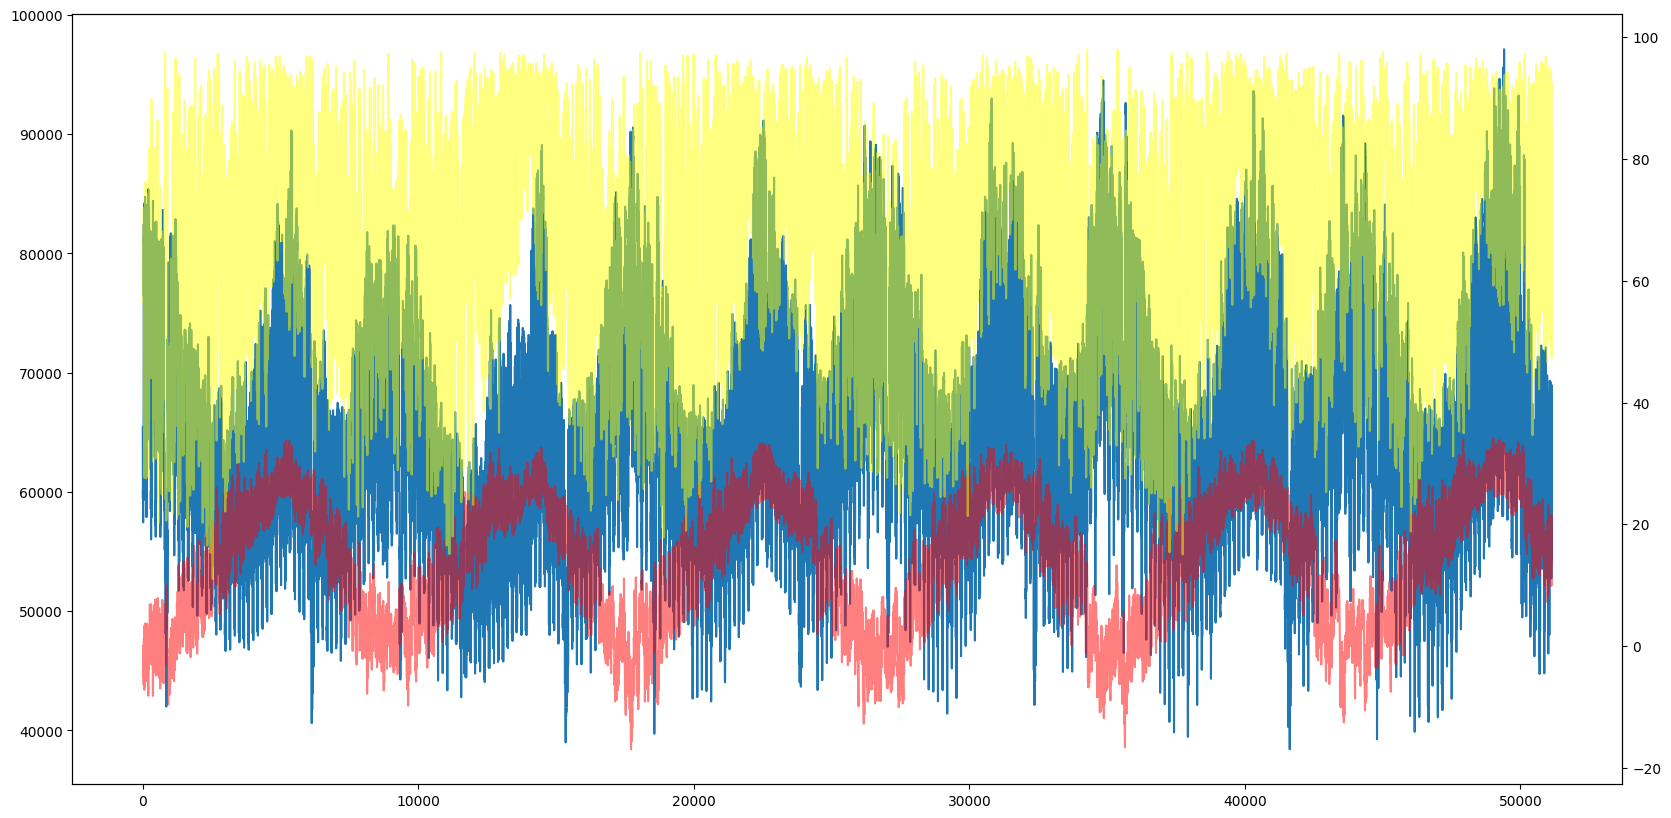

In [26]:
fig, axs = plt.subplots(figsize=(20,10))

plt.plot(total_data["power demand(MW)"])

axs1 = axs.twinx()
axs1.plot(total_data[["ta"]], color = "red", alpha = 0.5) # 
axs1.plot(total_data[["hm"]], color = "yellow", alpha = 0.5) # 